# Non-Linear Convolutional Neural Network using Sign Language Dataset

In this case study a non-linear Convolutional Network was created using Keras' Functional API, in order to classify the numbers 0 to 5 in the Sign Language

## Table of Contents

- [1 - Packages](#1)
    - [1.1 Useful Functions: Loading the Dataset, One-Hot-Encoding](#1-1)
- [2 - Using the Functional API](#2)
    - [2.1 - SIGNS Dataset](#2-1)
    - [2.2 - Splitting the Data into Train/Test Sets](#2-2)
    - [2.3 - Building the Model](#2-3)
    - [2.4 - Training the Model](#2-4)
- [3 - Visualizing the loss and the accuracy of the object](#3)

<a name = '1'></a>
## 1 - Packages

In [23]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

<a name='1-1'></a>
### 1.1 Useful Functions: Loading the Dataset, One-Hot-Encoding

In [56]:
def load_signs_dataset():
    # Train set features & labels
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig, train_set_y_orig = np.array(train_dataset["train_set_x"][:]), np.array(train_dataset["train_set_y"][:]) 
    
    # Test set features & labels
    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig, test_set_y_orig = np.array(test_dataset["test_set_x"][:]), np.array(test_dataset["test_set_y"][:])

    # Reshaping the label data
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

def one_hot_encoding(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

<a name='2'></a>
## 2 - Using the Functional API

For this model the Keras' [Functional API](https://www.tensorflow.org/guide/keras/functional) was used. The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. 

In the visual example below, the one possible direction of the movement Sequential model is shown in contrast to a skip connection, which is just one of the many ways a Functional model can be constructed. A skip connection, as you might have guessed, skips some layer in the network and feeds the output to a later layer in the network.

<img src="seq_vs_func.png" style="width:350px;height:200px;">

<a name='2-1'></a>
### 2.1 - SIGNS Dataset

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [57]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_signs_dataset() #Loading the Dataset

<img src="SIGNS.png" style="width:800px;height:300px;">

The next cell shows an example of a labelled image in the dataset.

y = 1


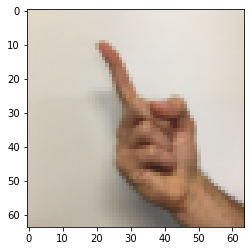

In [39]:
# Example of an image from the dataset
index = 11                                               # Index of the image
plt.imshow(X_train_orig[index])                          # Plotting the image
print ("y = " + str(np.squeeze(Y_train_orig[:, index]))) # Printing the number (label) that the sign corresponds to

<a name='2-2'></a>
### 2.2 - Splitting the Data into Train/Test Sets

In [52]:
X_train = X_train_orig/255.                                         # Normalizing the Training Features
X_test = X_test_orig/255.                                           # Normalizing the Testing Features
Y_train = one_hot_encoding(Y_train_orig, 6).T                       # Applying One-Hot Encoding to the Training Labels
Y_test = one_hot_encoding(Y_test_orig, 6).T                         # Applying One-Hot Encoding to the Testing Labels

print (f"number of training examples: {X_train.shape[0]}, number of test examples = {X_test.shape[0]}")
print (f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print (f"X_test shape:  {X_test.shape},  Y_test shape:  {Y_test.shape}")

number of training examples: 1080, number of test examples = 120
X_train shape: (1080, 64, 64, 3), Y_train shape: (1080, 6)
X_test shape:  (120, 64, 64, 3),  Y_test shape:  (120, 6)


<a name='2-3'></a>
### 2.3 - Building the Model

In TensorFlow, there are built-in functions that implement the Convolution steps.

The following model could also be defined using the Sequential API since the information flow is on a single line, but the purpose of doing it this way was to show a non-linear model using the Keras' Functional API.

In [24]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)                                          # The Input Layer
    Z1 = tfl.Conv2D(filters=8, kernel_size=(4,4), strides=(1,1),padding='SAME')(input_img) # The Conv2D Layer with: 8 filters sized 4x4, stride of 1 and padding =='SAME'
    A1 = tfl.ReLU()(Z1)                                                                    # The ReLU Layer with default settings
    P1 = tfl.MaxPool2D(pool_size=(8,8),strides=8,padding='SAME')(A1)                       # The MaxPool2D Layer with: window size of 8x8, a stride of 8 and padding == 'SAME'
    Z2 = tfl.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1),padding='SAME')(P1)       # The Conv2D Layer with: 16 filters sized 2x2, stride of 1 and padding =='SAME'
    A2 = tfl.ReLU()(Z2)                                                                    # The ReLU Layer with default settings
    P2 = tfl.MaxPool2D(pool_size=(4,4),strides=4,padding='SAME')(A2)                       # The MaxPool2D Layer with: window size of 4x4, a stride of 4 and padding == 'SAME'
    F = tfl.Flatten()(P2)                                                                  # The Flatten Layer with default settings
    outputs = tfl.Dense(units=6, activation='softmax')(F)                                  # The Fully-Connected (Dense) Layer with 6 units and Softmax activation function
    model = tf.keras.Model(inputs=input_img, outputs=outputs)                              # Building the Model from the Layers
    
    return model

In [25]:
conv_model = convolutional_model((64, 64, 3))                                               # Building the Model
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the Model
conv_model.summary()                                                                        # Getting a summary of the Model

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 16)          0   

<a name='2-4'></a>
### 2.4 - Training the Model

The model is trained on the Dataset using `.fit()`

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)        # Slicing the Train Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)           # Slicing the Test Dataset
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)       # Training the Model

Epoch 1/100
17/17 [==============================] - 8s 492ms/step - loss: 1.8445 - accuracy: 0.1667 - val_loss: 1.7934 - val_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 3s 180ms/step - loss: 1.7861 - accuracy: 0.1991 - val_loss: 1.7863 - val_accuracy: 0.2417
Epoch 3/100
17/17 [==============================] - 3s 182ms/step - loss: 1.7808 - accuracy: 0.2519 - val_loss: 1.7815 - val_accuracy: 0.1833
Epoch 4/100
17/17 [==============================] - 3s 169ms/step - loss: 1.7762 - accuracy: 0.2769 - val_loss: 1.7793 - val_accuracy: 0.1917
Epoch 5/100
17/17 [==============================] - 3s 180ms/step - loss: 1.7713 - accuracy: 0.3287 - val_loss: 1.7752 - val_accuracy: 0.3000
Epoch 6/100
17/17 [==============================] - 3s 159ms/step - loss: 1.7651 - accuracy: 0.3426 - val_loss: 1.7703 - val_accuracy: 0.2833
Epoch 7/100
17/17 [==============================] - 3s 152ms/step - loss: 1.7579 - accuracy: 0.3481 - val_loss: 1.7648 - val_accuracy: 0.2750

<a name='3'></a>
## 3 - Visualizing the loss and the accuracy of the object

The history object is a dictionary output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

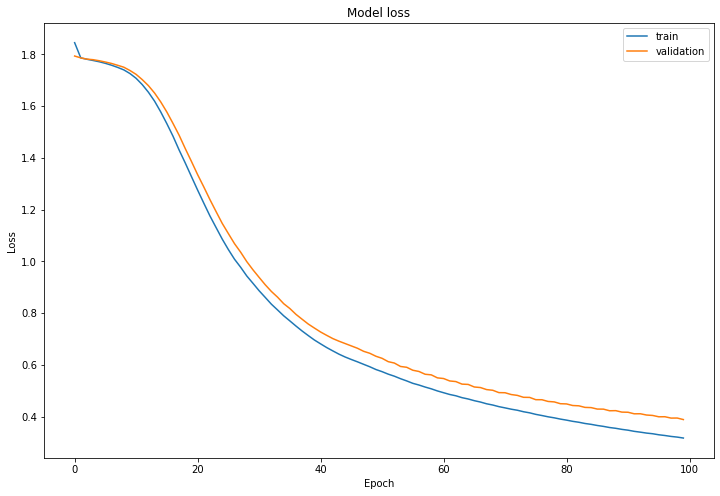

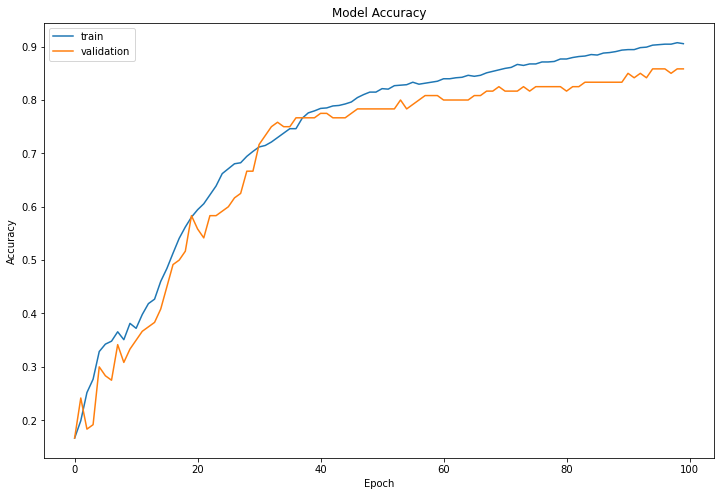

In [35]:
df_loss = pd.DataFrame({'train': history.history['loss'],     'validation': history.history['val_loss']})      # Building a DataFrame with the Loss metrics of the Model
df_acc  = pd.DataFrame({'train': history.history['accuracy'], 'validation': history.history['val_accuracy']})  # Building a DataFrame with the Accuracy metrics of the Model
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')                              # Plotting the Loss DataFrame
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')                       # Plotting the Accuracy DataFrame

The model shows an accuracy of **80%** on the validation set.